# Задание 6

## Задача 2:
Просэмплировать варианты нейросетей по сетке, сделать 3d-график, каждая точка которого соответствует модели, а координаты:

Количество параметров нейросети
Точность модели
Устойчивость модели под действием adverarial-атак (рекомендуется брать FGSM, параметр epsiilon подобрать самостоятельно из соображений наглядности графика) На графике также отметить парето-оптимальный фронт. Допускается использование логарифмической шкалы для наглядности.
Сетка нейросетей: полносвязные нейросети с 1, 2, 3 и 0 (логистическая регрессия) количеством слоев. Количество точек на графике должно быть не менее 20.

Выборка: Fasion-MNIST.

Парето-оптимальный фронт
FGSM

### Исполнитель:
Бишук Антон Юрьевич

In [30]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def count_n_params(model):
    sum_params=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        sum_params += nn
    return sum_params

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,),)])


trainset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64)

In [6]:
class FullNet(nn.Module):
  def __init__(self, dims):
    super().__init__()
    self.net = []
    for dim in dims:
        self.net.append(nn.Linear(dim[0], dim[1]))
    self.net = nn.Sequential(*self.net)

  def forward(self, x):
    x = x.view(x.shape[0],-1)
    return F.log_softmax(self.net(x), dim=1)

In [42]:
def train(model, device, train_loader, n_epochs):
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for e in range(n_epochs):
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

    return model

def test(model, device, test_loader, epsilon):

    # Accuracy counter
    stability = 0
    accuracy = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        with torch.no_grad():
            stability += (final_pred.T[0].cpu().numpy() == init_pred.T[0].cpu().numpy()).sum()
            accuracy += (init_pred.T[0].cpu().numpy() == target.cpu().numpy()).sum()

    return (count_n_params(model), accuracy / (len(test_loader)*64), stability / (len(test_loader) * 64))

In [43]:
def count_metrics(pipline, device, epsilon, train_loader, test_loader):
    results = []
    for p_dict in tqdm(pipline):
        model = train(FullNet(p_dict['layers']).to(device), device, train_loader, p_dict['n_epoch'])
        results.append(test(model, device, test_loader, epsilon))

    return results

### Обозначим точки, которые будут на нашем графике

In [44]:
pipline = [# 0 скрытых слоев
           {'n_epoch':5, 'layers':[[784, 10]]},
           {'n_epoch':10, 'layers':[[784, 10]]},
           {'n_epoch':20, 'layers':[[784, 10]]},
           # 1 скрытый слой
           {'n_epoch':5, 'layers':[[784, 128],[128, 10]]},
           {'n_epoch':10, 'layers':[[784, 128],[128, 10]]},
           {'n_epoch':20, 'layers':[[784, 128],[128, 10]]},
           {'n_epoch':5, 'layers':[[784, 256],[256, 10]]},
           {'n_epoch':10, 'layers':[[784, 256],[256, 10]]},
           {'n_epoch':20, 'layers':[[784, 256],[256, 10]]},
           {'n_epoch':5, 'layers':[[784, 512],[512, 10]]},
           {'n_epoch':10, 'layers':[[784, 512],[512, 10]]},
           {'n_epoch':20, 'layers':[[784, 512],[512, 10]]},
           # 2 скрытых слоя
           {'n_epoch':5, 'layers':[[784, 256],[256, 128],[128, 10]]},
           {'n_epoch':10, 'layers':[[784, 256],[256, 128],[128, 10]]},
           {'n_epoch':20, 'layers':[[784, 256],[256, 128],[128, 10]]},
           {'n_epoch':5, 'layers':[[784, 256],[256, 256],[256, 10]]},
           {'n_epoch':10, 'layers':[[784, 256],[256, 256],[256, 10]]},
           {'n_epoch':20, 'layers':[[784, 256],[256, 256],[256, 10]]},
           {'n_epoch':5, 'layers':[[784, 512],[512, 256],[256, 10]]},
           {'n_epoch':10, 'layers':[[784, 512],[512, 256],[256, 10]]},
           {'n_epoch':20, 'layers':[[784, 512],[512, 256],[256, 10]]},
           {'n_epoch':5, 'layers':[[784, 512],[512, 512],[512, 10]]},
           {'n_epoch':10, 'layers':[[784, 512],[512, 512],[512, 10]]},
           {'n_epoch':20, 'layers':[[784, 512],[512, 512],[512, 10]]},
]

### Запустим подсчет метрик для построения графика

In [46]:
epsilon = 0.15

metrics = count_metrics(pipline, device, epsilon, trainloader, testloader)

  0%|          | 0/24 [00:00<?, ?it/s]

In [47]:
metrics

[(7850, 0.8171775477707006, 0.38893312101910826),
 (7850, 0.8333001592356688, 0.34942277070063693),
 (7850, 0.8358877388535032, 0.3205613057324841),
 (101770, 0.8238455414012739, 0.36315684713375795),
 (101770, 0.8336982484076433, 0.3297173566878981),
 (101770, 0.832703025477707, 0.28403662420382164),
 (203530, 0.8205613057324841, 0.38395700636942676),
 (203530, 0.8331011146496815, 0.32852308917197454),
 (203530, 0.8365843949044586, 0.28015525477707004),
 (407050, 0.8272292993630573, 0.3700238853503185),
 (407050, 0.8356886942675159, 0.3268312101910828),
 (407050, 0.8382762738853503, 0.2718949044585987),
 (235146, 0.8309116242038217, 0.3587778662420382),
 (235146, 0.8363853503184714, 0.3000597133757962),
 (235146, 0.8306130573248408, 0.25019904458598724),
 (269322, 0.8283240445859873, 0.35011942675159236),
 (269322, 0.8340963375796179, 0.3078224522292994),
 (269322, 0.8407643312101911, 0.24950238853503184),
 (535818, 0.8240445859872612, 0.35400079617834396),
 (535818, 0.838077229299363

### Построим график

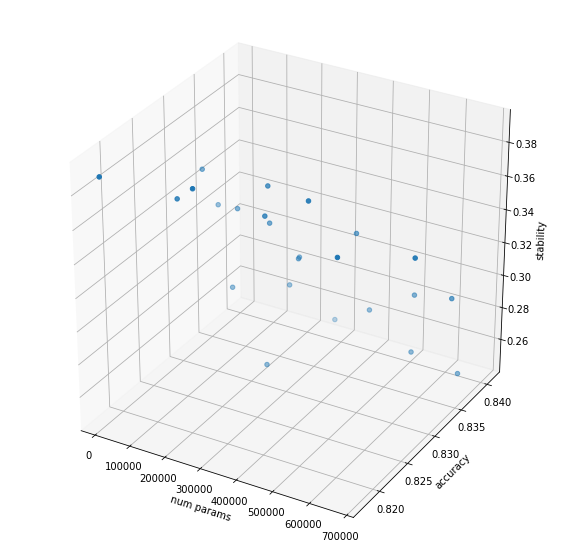

In [48]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

params = [p for (p, _, _) in metrics]
accuracy = [acc for (_, acc, _) in metrics]
stability = [stab for (_, _, stab) in metrics]

ax.scatter(params, accuracy, stability) # plot the point (2,3,4) on the figure

ax.set_xlabel('num params')
ax.set_ylabel('accuracy')
ax.set_zlabel('stability')

plt.show()

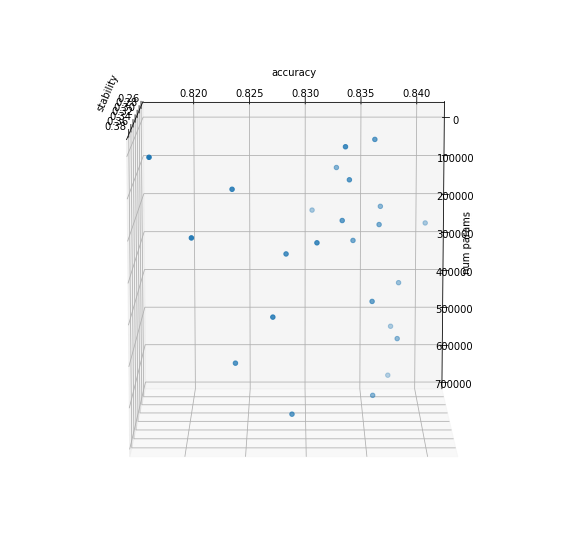

In [52]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

params = [p for (p, _, _) in metrics]
accuracy = [acc for (_, acc, _) in metrics]
stability = [stab for (_, _, stab) in metrics]

ax.scatter(params, accuracy, stability) # plot the point (2,3,4) on the figure

ax.set_xlabel('num params')
ax.set_ylabel('accuracy')
ax.set_zlabel('stability')
ax.view_init(100, 0)

plt.show()

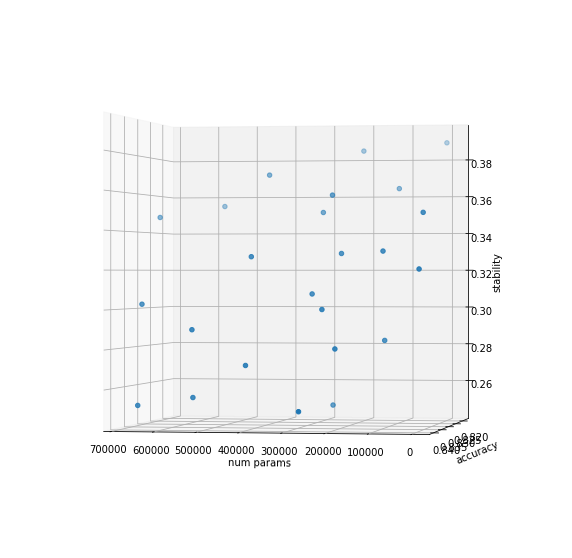

In [53]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111, projection='3d')

params = [p for (p, _, _) in metrics]
accuracy = [acc for (_, acc, _) in metrics]
stability = [stab for (_, _, stab) in metrics]

ax.scatter(params, accuracy, stability) # plot the point (2,3,4) on the figure

ax.set_xlabel('num params')
ax.set_ylabel('accuracy')
ax.set_zlabel('stability')
ax.view_init(0, 100)

plt.show()

### Вывод:

Возможно нужно было дольше обучать более сложные сети, но очевидной зависимости между число параметров и стабильностью не наблюдается.